In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import os
import tqdm
import glob
import tensorflow

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import to_categorical
from keras import optimizers
from tensorflow.keras.optimizers import Adam

from keras.callbacks import Callback,ModelCheckpoint,ReduceLROnPlateau
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

from typeguard import typechecked
from typing import Optional

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,     
                                    rotation_range=5,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [4]:
train_dataset  = train_datagen.flow_from_directory(directory = './chest_Xray/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   batch_size = 64)

Found 5216 images belonging to 2 classes.


In [5]:
valid_dataset = valid_datagen.flow_from_directory(directory = './chest_Xray/val',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

Found 16 images belonging to 2 classes.


In [6]:
test_dataset = test_datagen.flow_from_directory(directory = './chest_Xray/test',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

Found 624 images belonging to 2 classes.


In [7]:
base_model = tf.keras.applications.VGG16(input_shape=(224,224,3),include_top=False,weights="imagenet")

In [8]:
for layer in base_model.layers[:-8]:
    layer.trainable=False

In [9]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(2,activation='softmax'))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 7, 7, 512)         0         
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 batch_normalization (BatchN  (None, 25088)            100352    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                802848    
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                        

In [11]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [12]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [13]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 3,verbose = 1,factor = 0.50, min_lr = 1e-7)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=3)

In [14]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

In [15]:
%time
tf.keras.backend.clear_session()
history=model.fit(train_dataset,validation_data=valid_dataset,epochs = 5,verbose = 1,callbacks=[lrd,mcp,es])

Wall time: 0 ns
Epoch 1/5
82/82 [==============================] - 1230s 15s/step - loss: 0.5660 - accuracy: 0.7304 - precision: 0.7304 - recall: 0.7304 - auc: 0.7900 - f1_score: 0.7313 - val_loss: 1.7781 - val_accuracy: 0.6250 - val_precision: 0.6250 - val_recall: 0.6250 - val_auc: 0.6797 - val_f1_score: 0.6250 - lr: 0.0010
Epoch 2/5
82/82 [==============================] - 1194s 15s/step - loss: 0.3215 - accuracy: 0.8714 - precision: 0.8714 - recall: 0.8714 - auc: 0.9422 - f1_score: 0.8710 - val_loss: 8.8370 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.5000 - val_auc: 0.5000 - val_f1_score: 0.5000 - lr: 0.0010
Epoch 3/5
82/82 [==============================] - 1220s 15s/step - loss: 0.2125 - accuracy: 0.9218 - precision: 0.9218 - recall: 0.9218 - auc: 0.9740 - f1_score: 0.9215 - val_loss: 1.0064 - val_accuracy: 0.6875 - val_precision: 0.6875 - val_recall: 0.6875 - val_auc: 0.8242 - val_f1_score: 0.6875 - lr: 0.0010
Epoch 4/5
82/82 [==============================] - 

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 7, 7, 512)         0         
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 batch_normalization (BatchN  (None, 25088)            100352    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                802848    
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                        

10/10 [==============================] - 79s 8s/step


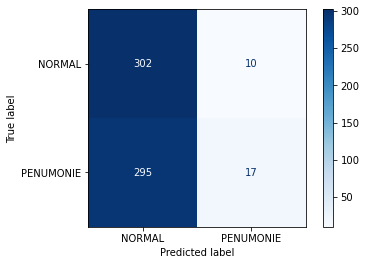

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Convertir les labels en un format numérique
labels = ['NORMAL', 'PNEUMONIE']*312

le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

predictions = model.predict(test_dataset, workers=2, max_queue_size=10)
predicted_classes = np.argmax(predictions, axis=1)


# Calculer la matrice de confusion
cm = confusion_matrix(labels_encoded, predicted_classes)

# Afficher la matrice de confusion sous forme de heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['NORMAL', 'PENUMONIE'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [20]:
result = model.evaluate(test_dataset, verbose=1)

10/10 [==============================] - 76s 7s/step - loss: 2.5363 - accuracy: 0.4183 - precision: 0.4183 - recall: 0.4183 - auc: 0.5407 - f1_score: 0.4177


In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()